In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(), # convert PIL to PyTorch tensor and scales values to [0, 1]
    transforms.Normalize((0.5,), (0.5,)) # mean = 0.5, std = 0.5 -> (pixel - mean) / std -> range = [-1, 1]
])

In [4]:
# train set has 50,000 and
# test set has 10,000 images
trainset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
epochs = 100

train_data = trainset.data
train_targets = np.array(trainset.targets)

fold_train_losses = []
fold_val_losses = []

In [6]:
model = nn.Sequential(
    # input: 1 channel (grayscale),
    # output: 16 channels
    # padding: 1 keeps the spatial dimensions
    nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), 
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),

    # converts 3D feature maps
    # to 1D vector -> output size: 64*40*30 (channels*height*width)
    nn.Flatten(),

    nn.Linear(1024, 120), # 120 neurons
    nn.ReLU(),
    nn.Linear(120, 10) # 10 neurons for each class
).to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001) # L2 regularization

In [8]:
for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
    print(f'Fold {fold+1}/{k_folds}')
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = torch.utils.data.DataLoader(
        trainset,
        batch_size=8,
        sampler=train_subsampler,
        num_workers=2)
    
    val_loader = torch.utils.data.DataLoader(
        trainset,
        batch_size=8,
        sampler=val_subsampler,
        num_workers=2)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [9]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # forward pass
        optimizer.zero_grad()
        outputs = model(inputs)

        # backward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

fold_train_losses.append(train_losses)
fold_val_losses.append(val_losses)
print('training done')

Epoch [10/100], Train Loss: 0.7162, Val Loss: 0.8076
Epoch [20/100], Train Loss: 0.6402, Val Loss: 0.7832
Epoch [30/100], Train Loss: 0.6073, Val Loss: 0.7618
Epoch [40/100], Train Loss: 0.5881, Val Loss: 0.7439
Epoch [50/100], Train Loss: 0.5798, Val Loss: 0.7273
Epoch [60/100], Train Loss: 0.5681, Val Loss: 0.7490
Epoch [70/100], Train Loss: 0.5612, Val Loss: 0.7493
Epoch [80/100], Train Loss: 0.5584, Val Loss: 0.7866
Epoch [90/100], Train Loss: 0.5555, Val Loss: 0.7318
Epoch [100/100], Train Loss: 0.5487, Val Loss: 0.7404
training done


In [10]:
avg_train_losses = np.mean(fold_train_losses, axis=0)
avg_val_losses = np.mean(fold_val_losses, axis=0)

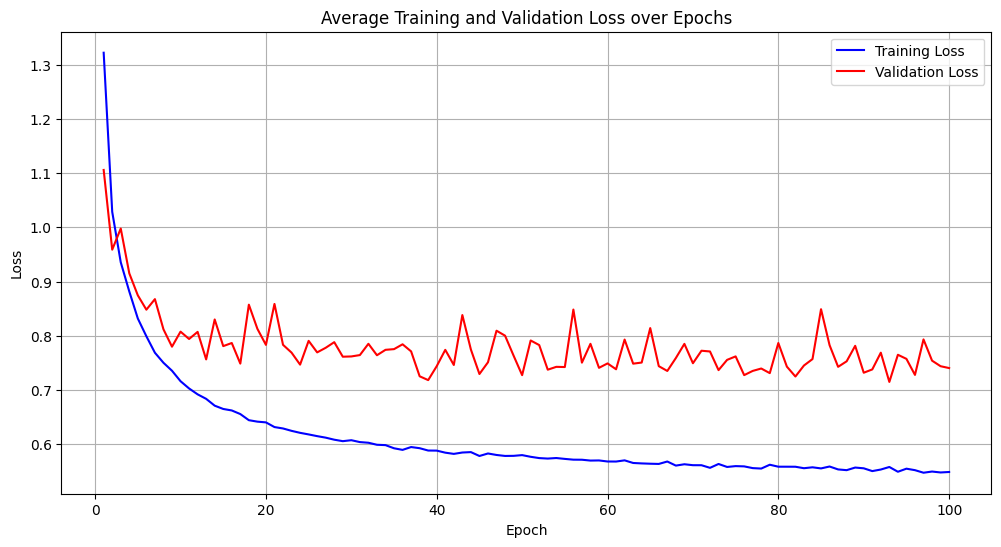

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), avg_train_losses, 'b-', label='Training Loss')
plt.plot(range(1, epochs + 1), avg_val_losses, 'r-', label='Validation Loss')
plt.title('Average Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
test_loader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy on test images: {accuracy:.2%}')
print(f'F1 Score: {f1:.4f}')

Accuracy on test images: 75.07%
F1 Score: 0.7500
